In [55]:
import pandas as pd
import json
import ndjson
import dask.bag as db
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from textblob import TextBlob

In [3]:
user_tweets_bag = db.read_text("D:/Research/causal_inference_data2/retweeters/*.ndjson").map(json.loads)

In [4]:
filtered = user_tweets_bag.filter(lambda x: x["created_at"] > "2019-12-20").map(json.dumps)
with ProgressBar():
    filtered.to_textfiles("D:/Research/causal_inference_data2/retweeters_filtered.json")

[########################################] | 100% Completed |  2hr 34min 35.6s


# Perliminary Analysis

In [28]:
import pandas as pd

In [46]:
user_tweets_bag = db.read_text("D:/Research/causal_inference_data2/retweeters_filtered.json/*.part")\
                    .map(json.loads)\
                    .map(
                        lambda x: {
                            "id": x["id"],
                            "user": x["user"],
                            "created_at": x["created_at"],
                            "retweet_id": x.get("retweeted_status", {}).get("id", -1),
                            "sentiment_polarity": TextBlob(x["full_text"]).sentiment.polarity,
                            "sentiment_subjectivity": TextBlob(x["full_text"]).sentiment.subjectivity
                        }
                    )

In [47]:
user_tweets = user_tweets_bag.to_dataframe(meta={
    "id": "int64", "user": "object", "created_at": "datetime64[ns, UTC]", "retweet_id": "int64", 
    "sentiment_polarity": "float64", "sentiment_subjectivity": "float64"
})

In [49]:
user_tweets["user_id"] = user_tweets["user"].apply(lambda x: x["id"], meta="int64")

In [50]:
user_tweets.head()

id                                               user  \
0  1220794997185839106  {'id': 1000083993382019074, 'id_str': '1000083...   
1  1220197769601744897  {'id': 1000083993382019074, 'id_str': '1000083...   
2  1220197039595802625  {'id': 1000083993382019074, 'id_str': '1000083...   
3  1220196355471298560  {'id': 1000083993382019074, 'id_str': '1000083...   
4  1220071621731459079  {'id': 1000083993382019074, 'id_str': '1000083...   

                 created_at  retweet_id  sentiment_polarity  \
0 2020-01-24 19:46:23+00:00          -1            0.000000   
1 2020-01-23 04:13:13+00:00          -1            0.458333   
2 2020-01-23 04:10:19+00:00          -1           -0.500000   
3 2020-01-23 04:07:35+00:00          -1            0.450000   
4 2020-01-22 19:51:57+00:00          -1            0.000000   

   sentiment_subjectivity              user_id  
0                     0.0  1000083993382019074  
1                     0.5  1000083993382019074  
2                     0.6  1000083993382019074  
3                     0.6  1000083993382019074  
4                     0.0  1000083993382019074

## Sentiment Analysis

In [53]:
mean_sentiment_by_hour = user_tweets.groupby(
    ["user_id", user_tweets["created_at"].dt.round("H")]
)["sentiment_polarity"].agg(["mean", "std", "max", "min", "sum", "count"])
with ProgressBar():
    mean_sentiment_by_hour.reset_index().to_json("D:/Research/causal_inference_data2/sentiment_by_hour.json")

[########################################] | 100% Completed |  5hr  5min 16.3s


In [56]:
summed = dd.read_json("D:/Research/causal_inference_data2/sentiment_by_hour.json/*")

In [67]:
with ProgressBar():
    res = summed.groupby(["user_id", summed["created_at"].dt.round("D")]).agg({"sum": ["sum"], "count": ["sum"]}).compute()

[########################################] | 100% Completed | 13.4s


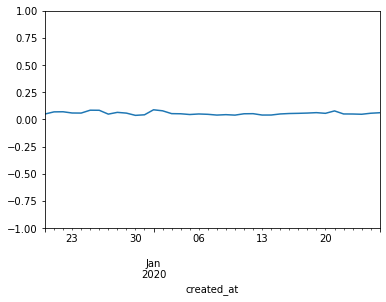

In [66]:
res["2019-12-20":].assign(polarity=lambda df: df["sum"]/df["count"])["polarity"].plot(ylim=(-1,1))

In [ ]:
res["2019-12-20":].assign(polarity=lambda df: df["sum"]/df["count"])["polarity"].plot(ylim=(-1,1))

In [76]:
r = res[res.index.get_level_values(1) >= "2019-12-20"].assign(polarity=lambda df: df["sum"]/df["count"])["polarity"].unstack(0)

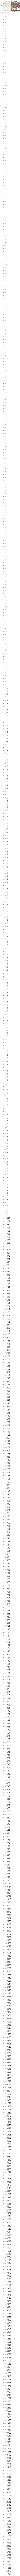

In [78]:
r.plot(ylim=(-1,1))

In [8]:
tweets = pd.DataFrame(ndjson.load(open("D:/Research/causal_inference_data2/realDonaldTrump.ndjson")))
retweets = json.load(open("D:/Research/causal_inference_data2/realDonaldTrump.ndjson.retweets.json"))

In [52]:
num_retweeters = pd.Series(retweets).apply(len)

In [53]:
(num_retweeters == 100).sum()

1

In [26]:
retweeted = tweets.set_index("id_str")[num_retweeters == 0]["retweeted_status"].apply(lambda tweet: tweet["id"]).unique()

In [93]:
len(tweets.set_index("id_str")[num_retweeters > 0])

426

In [30]:
len(set(retweeted) - set(tweets["id"].unique()))

541

In [44]:
retweeted = tweets.set_index("id_str")[num_retweeters == 0]["retweeted_status"].apply(
    lambda tweet: pd.Series({
        "id": tweet["id"], 
        "screen_name": tweet["user"]["screen_name"], 
        "created_at": tweet["created_at"]
    })
)

In [42]:
set(retweeted.loc[retweeted["screen_name"] == "realDonaldTrump", "id"].unique()) - set(tweets["id"].unique())

{1157094637624070144,
 1198027285921697793,
 1207055996687921152,
 1207277859519238154}

In [46]:
retweeted[retweeted["id"].isin({1157094637624070144,
 1198027285921697793,
 1207055996687921152,
 1207277859519238154})]

id      screen_name  \
id_str                                                      
1218168098966179842  1157094637624070144  realDonaldTrump   
1211799266974478337  1198027285921697793  realDonaldTrump   
1207723800823042050  1207055996687921152  realDonaldTrump   
1207323726498402310  1207277859519238154  realDonaldTrump   

                                         created_at  
id_str                                               
1218168098966179842  Fri Aug 02 01:03:54 +0000 2019  
1211799266974478337  Fri Nov 22 23:55:37 +0000 2019  
1207723800823042050  Tue Dec 17 21:52:30 +0000 2019  
1207323726498402310  Wed Dec 18 12:34:06 +0000 2019

In [47]:
tweets["created_at"].min()

'Fri Dec 20 00:16:46 +0000 2019'

In [54]:
import tweepy
CONSUMER_KEY="KQSoi13Fwql2VBwt5w4Fvwjuy"
CONSUMER_SECRET="pVEfydFKvFTwbBET7xiN22Q33UZXmUsWhlMy7P5IFvFWiH0CrH"
ACCESS_KEY="763797240561491968-HLCYojPtDbgISJa5ajjSuRlNYyPZI0m"
ACCESS_KEY_SECRET="Js2MSoe3UWHYCeaIOwB4EtTuaaXxJ6mJ98poXHG65rbY9"

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_KEY_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, api_root="/1.1", search_root=)

In [59]:
tweet = api.statuses_lookup(["1218168098966179842"])

In [61]:
a = tweet[0]

In [64]:
print(a._json.keys())

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])


In [73]:
a.retweeted_status._json.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

In [75]:
a.retweeted_status.id

'Thank you Cincinnati, Ohio. Together, we are going to KEEP AMERICA GREAT! https://t.co/sKPAW8e8qN'

In [77]:
a.in_reply_to_user_id

In [83]:
for page in tweepy.Cursor(api.retweeters, id=a.retweeted_status.id).pages():
    print(len(page))

47


In [88]:
a.retweeted_status.place

In [89]:
import requests

In [ ]:
"https://api.twitter.com/1.1/statuses/home_timeline.json"

In [90]:
resp = requests.post("https://api.twitter.com/oauth2/token", data={"grant_type": "client_credentials"})
resp.json()

{'errors': [{'code': 99,
   'message': 'Unable to verify your credentials',
   'label': 'authenticity_token_error'}]}

In [91]:
api.home_timeline??